# Set Huggingface Cache path

In [1]:
import os
# Set the HF_HOME environment variable
os.environ['HF_HOME'] = '/scratch365/dpan/hfcache'

# Load Dataset

In [2]:
from datasets import load_dataset 

# this dataset uses the new Image feature :)
dataset = load_dataset("nielsr/funsd-layoutlmv3")

/opt/crc/c/conda/23.5.2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
        num_rows: 149
    })
    test: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
        num_rows: 50
    })
})

In [4]:
dataset['train'].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER'], id=None), length=-1, id=None),
 'image': Image(decode=True, id=None)}

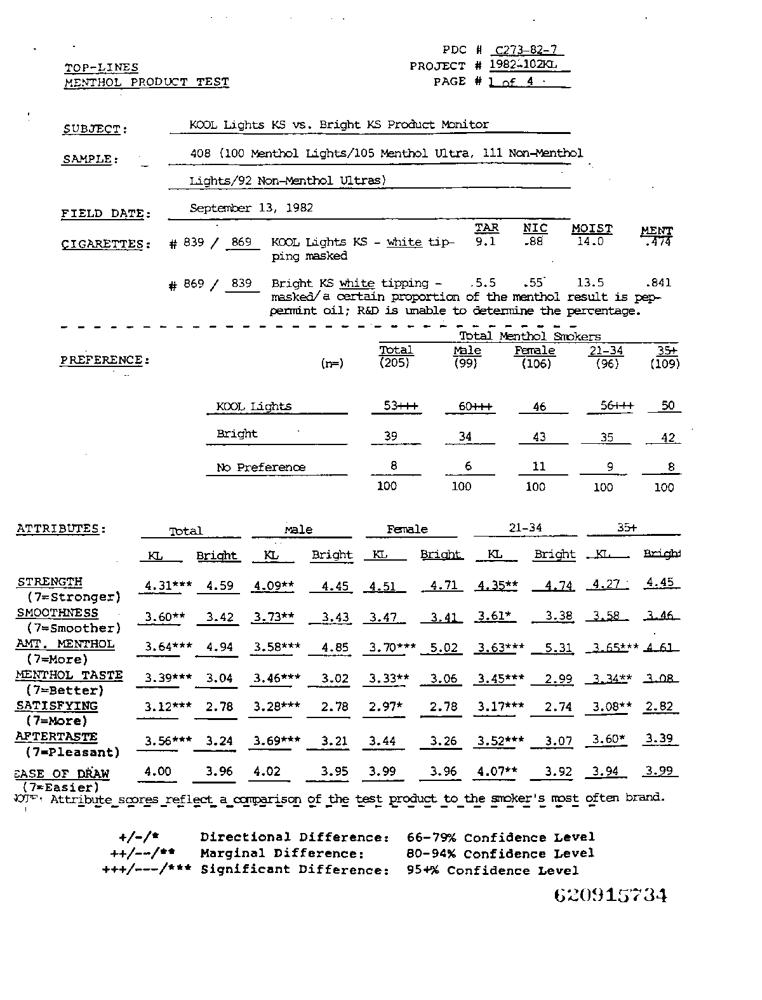

In [5]:
example = dataset["train"][3]
example["image"]

In [6]:
words, boxes, ner_tags = example["tokens"], example["bboxes"], example["ner_tags"]
print(words)
print(boxes)
print(ner_tags)

['SUBJECT:', 'SAMPLE:', 'CIGARETTES:', 'TAR', '9.1', 'NIC', '.88', 'MOIST', '14.0', 'MENT', '.841', 'PREFERENCE:', 'Bright', '39', '34', '43', '35', '42', '8', '9', '11', '6', '8', '200', '100', '100', '100', '100', 'ATTRIBUTES:', '53+++', '60+++', '46', '56+++', '50', '(n=)', 'Total', 'Male', 'Female', '35+', 'KL', 'Bright', 'KL', 'Bright', 'KL', 'Bright', 'KL', 'Bright', 'KL', 'Bright', '4.51', '4.45', '4.09**', '4.59', '4.31***', '3.60**', '3.64***', '3.39***', '3.12***', '3.56***', '4.00', '3.42', '3.73**', '3.58***', '4.94', '3.04', '3.46***', '3.28***', '2.78', '3.24', '3.96', '4.02', '3.69***', '3.02', '2.78', '3.21', '3.95', '3.99', '3.44', '2.97*', '3.33**', '3.70***', '3.47', '3.43', '4.85', '4.71', '3.41', '5.02', '3.06', '2.78', '3.26', '3.96', '4.35**', '3.61*', '3.63***', '3.45***', '3.17***', '3.52***', '4.07**', '4.74', '3.38', '5.31', '2.99', '2.74', '3.07', '3.92', '4.27', '3.58', '3.65***', '2.34**', '3.08**', '3.60*', '3.94', '4.45', '3.46', '4.61', '2.08', '2.82', 

# Prepare dataset

In [7]:
from transformers import AutoProcessor
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

In [8]:
from datasets.features import ClassLabel

features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "tokens"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels.union(set(label))
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

In [9]:
print(label_list)
print(id2label)

['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']
{0: 'O', 1: 'B-HEADER', 2: 'I-HEADER', 3: 'B-QUESTION', 4: 'I-QUESTION', 5: 'B-ANSWER', 6: 'I-ANSWER'}


In [10]:
def prepare_examples(examples):
    images = examples[image_column_name]
    words = examples[text_column_name]
    boxes = examples[boxes_column_name]
    word_labels = examples[label_column_name]

    encoding = processor(images, words, boxes=boxes, word_labels=word_labels, padding="max_length", truncation=True)

    return encoding

In [11]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

train_dataset = dataset["train"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)
eval_dataset = dataset["test"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

In [12]:
train_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 149
})

In [13]:
example = train_dataset[3]
processor.tokenizer.decode(example["input_ids"])

"<s> SUBJECT: SAMPLE: CIGARETTES: TAR 9.1 NIC.88 MOIST 14.0 MENT.841 PREFERENCE: Bright 39 34 43 35 42 8 9 11 6 8 200 100 100 100 100 ATTRIBUTES: 53+++ 60+++ 46 56+++ 50 (n=) Total Male Female 35+ KL Bright KL Bright KL Bright KL Bright KL Bright 4.51 4.45 4.09** 4.59 4.31*** 3.60** 3.64*** 3.39*** 3.12*** 3.56*** 4.00 3.42 3.73** 3.58*** 4.94 3.04 3.46*** 3.28*** 2.78 3.24 3.96 4.02 3.69*** 3.02 2.78 3.21 3.95 3.99 3.44 2.97* 3.33** 3.70*** 3.47 3.43 4.85 4.71 3.41 5.02 3.06 2.78 3.26 3.96 4.35** 3.61* 3.63*** 3.45*** 3.17*** 3.52*** 4.07** 4.74 3.38 5.31 2.99 2.74 3.07 3.92 4.27 3.58 3.65*** 2.34** 3.08** 3.60* 3.94 4.45 3.46 4.61 2.08 2.82 3.39 3.99 620915734 +/-/* ++/--/** +++/---/*** Attribute scores reflectia a comparison of the test product to the smoker's most often brand NOTE TOP- LINES MENTHOL PRODUCT TEST C273- 82- 7 1982 102KL 1 of 4 PDC # PROJECT # PAGE # KOOL Lights KS vs. Bright KS Product Monitor 408 Menthol Lights / 105 Menthol Ultra, 111 Non- Menthol Lights / 92 Non- 

In [14]:
train_dataset.set_format("torch")
import torch 
example = train_dataset[3]
for k,v in example.items():
    print(k, v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


# Define metrics

In [15]:
from datasets import load_metric

metric = load_metric("seqeval")

/tmp/543666.1.gpu/ipykernel_1676138/3097260500.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/afs/crc.nd.edu/user/d/dpan/.local/lib/python3.11/site-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [16]:
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

# Define the model

In [17]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Define TraningArguments + Trainer

In [18]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="/scratch365/dpan/layoutlm_test",
                                  max_steps=1000,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  learning_rate=1e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=100,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

In [19]:
from transformers.data.data_collator import default_data_collator

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

/afs/crc.nd.edu/user/d/dpan/.local/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


# Train the model

In [20]:
trainer.train()

/afs/crc.nd.edu/user/d/dpan/.local/lib/python3.11/site-packages/transformers/modeling_utils.py:962: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,No log,0.620789,0.763050,0.835072,0.797438,0.787115
200,No log,0.577980,0.832700,0.870343,0.851105,0.816118
300,No log,0.487678,0.852506,0.887233,0.869523,0.838464
400,No log,0.498010,0.876274,0.897168,0.886598,0.850707
500,0.532700,0.509161,0.874519,0.903626,0.888835,0.849875
600,0.532700,0.525013,0.897398,0.908097,0.902716,0.851539
700,0.532700,0.549654,0.900976,0.917536,0.909180,0.868180
800,0.532700,0.616822,0.896117,0.917039,0.906457,0.863901
900,0.532700,0.612460,0.903704,0.909091,0.906389,0.859503
1000,0.128200,0.603123,0.899463,0.915549,0.907435,0.867110


/afs/crc.nd.edu/user/d/dpan/.local/lib/python3.11/site-packages/transformers/modeling_utils.py:962: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


TrainOutput(global_step=1000, training_loss=0.33047591400146487, metrics={'train_runtime': 574.552, 'train_samples_per_second': 3.481, 'train_steps_per_second': 1.74, 'total_flos': 523783817001984.0, 'train_loss': 0.33047591400146487, 'epoch': 13.33})

In [22]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained("/scratch365/dpan/layoutlm_test/checkpoint-1000")

In [23]:
example = dataset["test"][0]
print(example.keys())

dict_keys(['id', 'tokens', 'bboxes', 'ner_tags', 'image'])


In [24]:
image = example["image"]
words = example["tokens"]
boxes = example["bboxes"]
word_labels = example["ner_tags"]

encoding = processor(image, words, boxes=boxes, word_labels=word_labels, return_tensors="pt")
for k,v in encoding.items():
  print(k,v.shape)

input_ids torch.Size([1, 360])
attention_mask torch.Size([1, 360])
bbox torch.Size([1, 360, 4])
labels torch.Size([1, 360])
pixel_values torch.Size([1, 3, 224, 224])


In [25]:
with torch.no_grad():
  outputs = model(**encoding)

/afs/crc.nd.edu/user/d/dpan/.local/lib/python3.11/site-packages/transformers/modeling_utils.py:962: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [26]:
logits = outputs.logits
logits.shape

torch.Size([1, 360, 7])

In [27]:
predictions = logits.argmax(-1).squeeze().tolist()
print(predictions)

[5, 3, 4, 3, 3, 4, 5, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 6, 6, 6, 6, 6, 6, 6, 3, 3, 4, 4, 5, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 5, 6, 6, 6, 6, 6, 6, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [28]:
labels = encoding.labels.squeeze().tolist()
print(labels)

[-100, 3, -100, 3, -100, -100, 5, 3, -100, -100, 3, -100, 0, -100, -100, 5, -100, 6, -100, 6, -100, -100, 0, 0, 0, -100, 0, 0, -100, 0, -100, 0, 0, -100, 0, -100, 0, -100, -100, 0, -100, 1, 2, 2, 2, -100, 2, 1, -100, -100, -100, 2, -100, -100, 2, -100, -100, 2, 2, -100, 5, -100, -100, 6, -100, -100, 6, -100, 3, -100, 4, -100, 5, 6, -100, -100, 5, -100, -100, 6, -100, 6, -100, 3, -100, 4, -100, -100, 3, -100, 4, -100, -100, 5, -100, -100, 6, -100, 6, -100, 3, -100, 4, 4, -100, 4, -100, 4, 4, -100, -100, 5, 6, 6, 6, 6, -100, 6, -100, -100, 6, -100, -100, 6, -100, 3, -100, -100, 4, -100, -100, 4, -100, -100, 3, 4, -100, -100, -100, 1, 2, 2, 2, 2, -100, -100, 2, 2, 2, 2, -100, 2, -100, -100, -100, 2, 2, -100, 2, -100, -100, 2, 2, -100, 2, 2, -100, -100, 5, 6, -100, -100, -100, 6, 6, -100, 6, 6, 6, 6, 6, 6, 6, -100, -100, -100, 6, 6, -100, 6, 6, -100, 6, 6, 6, -100, -100, -100, 6, 6, 6, -100, 6, 6, 6, 6, -100, -100, -100, -100, -100, 6, -100, -100, -100, -100, 6, 6, -100, -100, 6, 6, -100, 

In [29]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

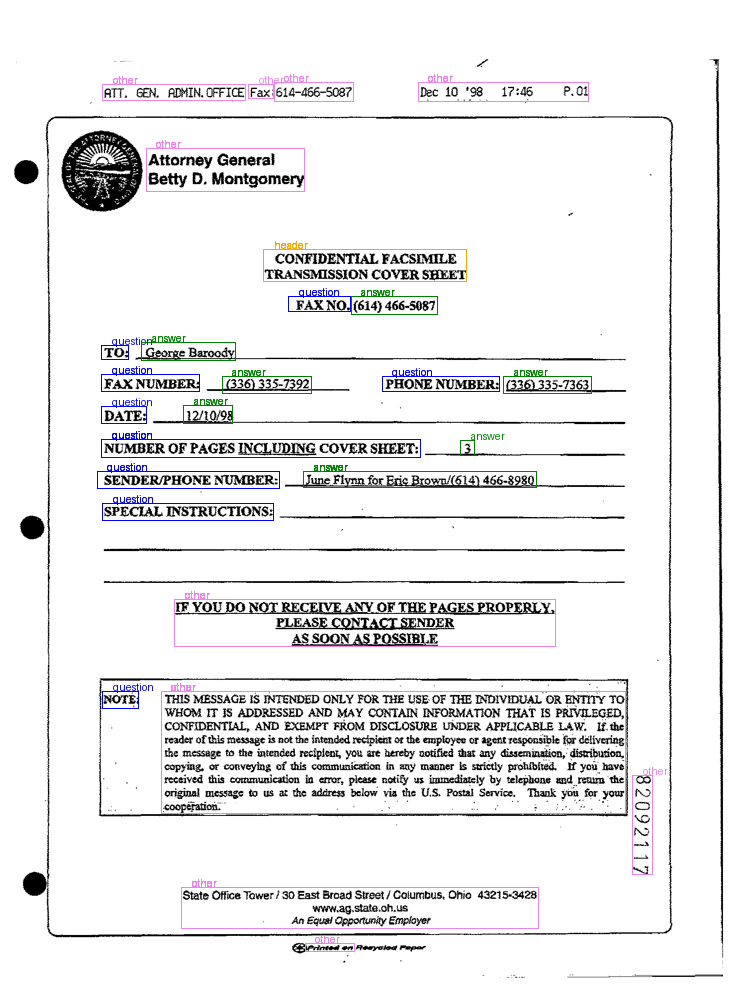

In [30]:
from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

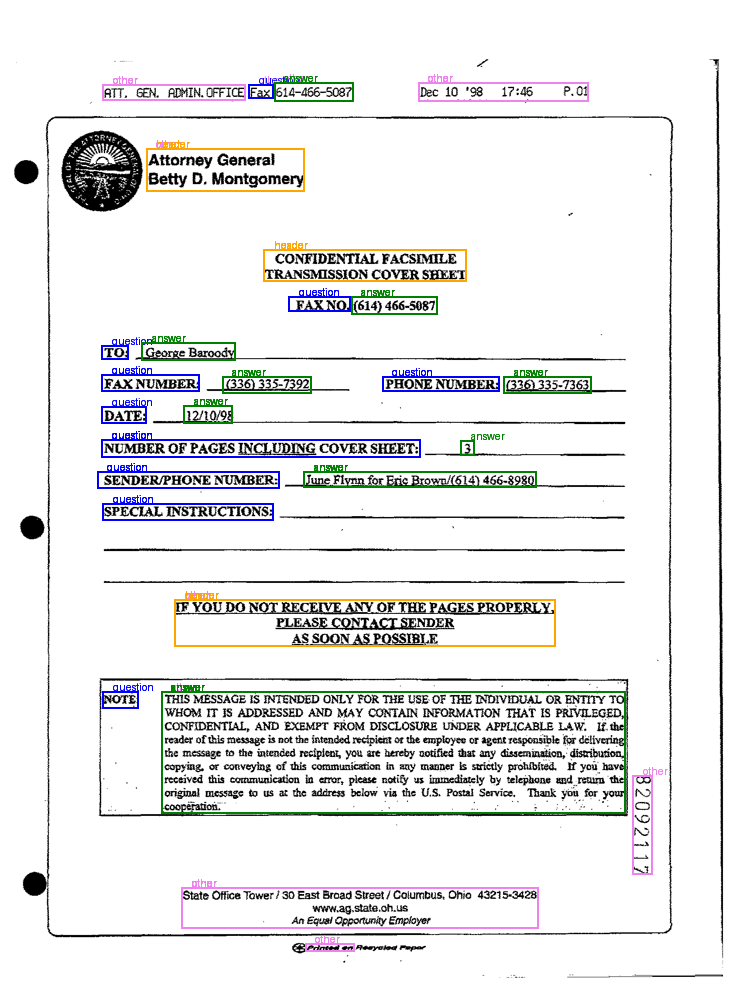

In [31]:
image = example["image"]
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

for word, box, label in zip(example['tokens'], example['bboxes'], example['ner_tags']):
  actual_label = iob_to_label(id2label[label]).lower()
  box = unnormalize_box(box, width, height)
  draw.rectangle(box, outline=label2color[actual_label], width=2)
  draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)

image

In [35]:
token_boxes

[[0, 0, 0, 0],
 [135, 345, 171, 359],
 [135, 345, 171, 359],
 [135, 406, 194, 423],
 [135, 406, 194, 423],
 [135, 406, 194, 423],
 [611, 440, 629, 455],
 [330, 84, 363, 98],
 [330, 84, 363, 98],
 [330, 84, 363, 98],
 [136, 691, 184, 708],
 [136, 691, 184, 708],
 [839, 775, 866, 874],
 [839, 775, 866, 874],
 [839, 775, 866, 874],
 [364, 82, 469, 101],
 [364, 82, 469, 101],
 [364, 82, 469, 101],
 [364, 82, 469, 101],
 [364, 82, 469, 101],
 [364, 82, 469, 101],
 [364, 82, 469, 101],
 [555, 82, 781, 101],
 [555, 82, 781, 101],
 [555, 82, 781, 101],
 [555, 82, 781, 101],
 [555, 82, 781, 101],
 [555, 82, 781, 101],
 [555, 82, 781, 101],
 [555, 82, 781, 101],
 [555, 82, 781, 101],
 [555, 82, 781, 101],
 [136, 84, 326, 100],
 [136, 84, 326, 100],
 [136, 84, 326, 100],
 [136, 84, 326, 100],
 [136, 84, 326, 100],
 [136, 84, 326, 100],
 [136, 84, 326, 100],
 [136, 84, 326, 100],
 [136, 84, 326, 100],
 [194, 148, 404, 191],
 [194, 148, 404, 191],
 [194, 148, 404, 191],
 [194, 148, 404, 191],
 [194